# Preprocessing
Replicate the preprocessing steps from `src/data/preprocessing.py`: enriching movies, building interaction matrices, and splitting into train/test sets.

In [1]:
import sys
from pathlib import Path

ROOT = Path().resolve().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data.loader import load_dataset
from src.data.preprocessing import (
    enrich_movies,
    cap_dataset,
    build_interaction_matrix,
    build_high_rating_matrix,
    temporal_train_test_split,
)

ds = load_dataset(ROOT / 'data' / 'raw', max_rows=200_000)
ratings, movies_raw = ds.ratings, ds.movies
print('Loaded', len(ratings), 'ratings')

Loaded 200000 ratings


In [2]:
# Enrich movies: extract year, assign primary genre
movies = enrich_movies(movies_raw)
print(movies[['movieId', 'title', 'year', 'primary_genre']].head(10).to_string(index=False))

 movieId                              title  year primary_genre
       1                   Toy Story (1995)  1995     Adventure
       2                     Jumanji (1995)  1995     Adventure
       3            Grumpier Old Men (1995)  1995        Comedy
       4           Waiting to Exhale (1995)  1995        Comedy
       5 Father of the Bride Part II (1995)  1995        Comedy
       6                        Heat (1995)  1995        Action
       7                     Sabrina (1995)  1995        Comedy
       8                Tom and Huck (1995)  1995     Adventure
       9                Sudden Death (1995)  1995        Action
      10                   GoldenEye (1995)  1995        Action


In [3]:
# Cap to active users/movies to keep demo fast
ratings_capped = cap_dataset(ratings, max_users=5000, max_movies=3000)
rated_ids = set(ratings_capped['movieId'].unique())
movies = movies[movies['movieId'].isin(rated_ids)].drop_duplicates('movieId').reset_index(drop=True)
print(f'After cap: {len(ratings_capped):,} ratings | {movies["movieId"].nunique():,} movies')

After cap: 170,641 ratings | 3,000 movies


In [4]:
# Temporal train / test split
train_df, test_df = temporal_train_test_split(ratings_capped, test_ratio=0.2, min_user_ratings_for_test=5)
print(f'Train: {len(train_df):,}  |  Test: {len(test_df):,}')

Train: 137,028  |  Test: 33,613


In [5]:
# Build sparse interaction matrix
bundle = build_interaction_matrix(train_df)
print('Matrix shape:', bundle.matrix.shape, '| density:', f'{bundle.matrix.nnz / (bundle.matrix.shape[0] * bundle.matrix.shape[1]):.4%}')

Matrix shape: (1302, 3000) | density: 3.5081%


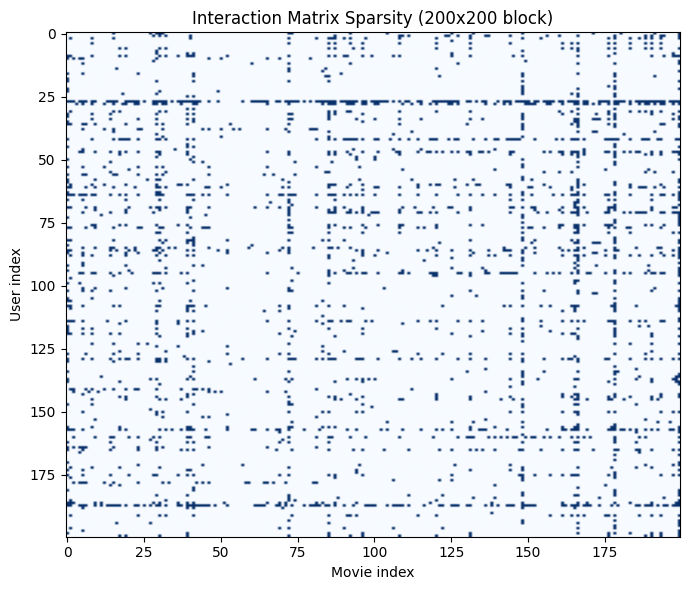

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sparsity visualisation — random 200x200 block
mat = bundle.matrix[:200, :200].toarray()
fig, ax = plt.subplots(figsize=(7, 6))
ax.imshow(mat > 0, cmap='Blues', aspect='auto')
ax.set_title('Interaction Matrix Sparsity (200x200 block)')
ax.set_xlabel('Movie index')
ax.set_ylabel('User index')
plt.tight_layout()
plt.show()